# Выбор оптимальной модели

В этом семинаре мы потренируемся обучению, оценке и валидации моделей, подбору оптимальных гиперпараметров, смешиванию моделей. Вам предлагается решить задачу бинарной классификации, а именно построить алгоритм, определяющий превысит ли средний заработок человека порог $50k.

Импортируем необходимые библиотеки. Загрузим данные, уберём пропущенные значения

In [0]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

In [0]:
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data')
# Назначаем имена колонок
columns = ('age workclass fnlwgt education educ-num marital-status occupation relationship '
           'race sex capital-gain capital-loss  hours-per-week native-country salary')

numeric_indices = np.array([0, 2, 4, 10, 11, 12])
categorical_indices = np.array([1, 3, 5, 6, 7, 8, 9, 13])

df.columns = columns.split() #этот метод разделит датасет по колонкам как в массиве columns

df = df.replace('?', np.nan)

df = df.dropna()

df['salary'] = df['salary'].apply((lambda x: x==' >50K')) # Будем предсказывать 1(True), если зарплата больше 50K, 0(False) иначе

In [0]:
numeric_data = df[df.columns[numeric_indices]]

categorial_data = df[df.columns[categorical_indices]]
dummy_features = pd.get_dummies(categorial_data)

In [4]:
X = pd.concat([numeric_data, dummy_features], axis=1)
X.head()

,age,fnlwgt,educ-num,capital-gain,capital-loss,hours-per-week,workclass_ ?,workclass_ Federal-gov,workclass_ Local-gov,workclass_ Never-worked,workclass_ Private,workclass_ Self-emp-inc,workclass_ Self-emp-not-inc,workclass_ State-gov,workclass_ Without-pay,education_ 10th,education_ 11th,education_ 12th,education_ 1st-4th,education_ 5th-6th,education_ 7th-8th,education_ 9th,education_ Assoc-acdm,education_ Assoc-voc,education_ Bachelors,education_ Doctorate,education_ HS-grad,education_ Masters,education_ Preschool,education_ Prof-school,education_ Some-college,marital-status_ Divorced,marital-status_ Married-AF-spouse,marital-status_ Married-civ-spouse,marital-status_ Married-spouse-absent,marital-status_ Never-married,marital-status_ Separated,marital-status_ Widowed,occupation_ ?,occupation_ Adm-clerical,...,native-country_ Canada,native-country_ China,native-country_ Columbia,native-country_ Cuba,native-country_ Dominican-Republic,native-country_ Ecuador,native-country_ El-Salvador,native-country_ England,native-country_ France,native-country_ Germany,native-country_ Greece,native-country_ Guatemala,native-country_ Haiti,native-country_ Holand-Netherlands,native-country_ Honduras,native-country_ Hong,native-country_ Hungary,native-country_ India,native-country_ Iran,native-country_ Ireland,native-country_ Italy,native-country_ Jamaica,native-country_ Japan,native-country_ Laos,native-country_ Mexico,native-country_ Nicaragua,native-country_ Outlying-US(Guam-USVI-etc),native-country_ Peru,native-country_ Philippines,native-country_ Poland,native-country_ Portugal,native-country_ Puerto-Rico,native-country_ Scotland,native-country_ South,native-country_ Taiwan,native-country_ Thailand,native-country_ Trinadad&Tobago,native-country_ United-States,native-country_ Vietnam,native-country_ Yugoslavia
0,50,83311,13,0,0,13,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,38,215646,9,0,0,40,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,53,234721,7,0,0,40,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,28,338409,13,0,0,40,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,37,284582,14,0,0,40,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [5]:
y = df['salary']
y.head()

0    False
1    False
2    False
3    False
4    False
Name: salary, dtype: bool

Теперь всё готово для обучения алгоритмов. Разбейте данные на train и test в соотношении 4:1.

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Кросс-валидация

![img](https://lh6.googleusercontent.com/IgkIPN6nKjXJEHnbesY2bDCmGkJjSBqtkkF_yLRWlHX_hmfSQpfTC4tyPF13XQsqy9yrqMW4VIjyov-BjuzQKzf4yfFbrSO6HiMgPq9u_Lh5-h2Sdv9k1Mw5rJIDckKdJZ3IeppZpnI)

Вместо того, чтобы отделять валидационную выборку от тренировочной, проверяя построенные модели на ней, будем использовать метод кросс-валидации, реализованный вместе с поиском по сетке в классе sklearn.model_selection.GridSearchCV. Суть метода заключается в том, что мы разбиваем обучающую выборку на n частей (фолдов), обучаем алгоритм на каждых из n-1 фолдов и измеряем качество предсказания на оставшемся фолде, а затем усредняем результаты по всем фолдам.

Напишем функцию, визуализирующую поиск оптимального гиперпараметра модели по сетке. 

In [0]:
from sklearn.model_selection import GridSearchCV

In [0]:
def search_and_draw(X, y, model, param_name, grid, param_scale='ordinary', draw=True):
    parameters = {param_name: grid}
    
    CV_model = GridSearchCV(estimator=model, param_grid=parameters, cv=5, scoring='roc_auc', n_jobs=-1)
    CV_model.fit(X, y)
    print(CV_model.best_params_)
    
    means = CV_model.cv_results_['mean_test_score']
    error = CV_model.cv_results_['std_test_score']
    
    if draw:
        plt.figure(figsize=(15,8))
        plt.title('choose ' + param_name)


        if (param_scale == 'log'):
            plt.xscale('log')

        plt.plot(grid, means, label='mean values of score')

        plt.fill_between(grid, means - 2 * error, means + 2 * error, label='2std', alpha=0.1)
        plt.legend()
        plt.xlabel('parameter')
        plt.ylabel('roc_auc')
        plt.show()
        
    return means, error

Для моделей K ближайших соседей и решающего дерева найдите оптимальные параметры n_neighbors и max_depth. Для алгоритма KNN достаточно ограничиться числом соседей не более 100 и размером сетки не более 20. 

In [0]:
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.tree import DecisionTreeClassifier 

In [0]:
models = [KNeighborsClassifier(), DecisionTreeClassifier()]
param_names = ['n_neighbors', 'max_depth']
grids = [[2,3,4,5], [4,5,6,7]] #ВАШ КОД: создайте сетки для перебора
param_scales = ['ordinary', 'ordinary']

{'n_neighbors': 4}


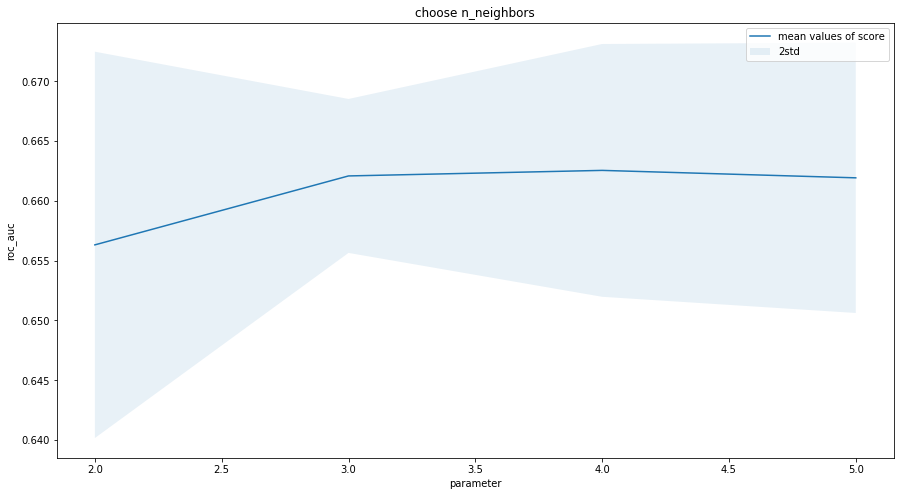

{'max_depth': 7}


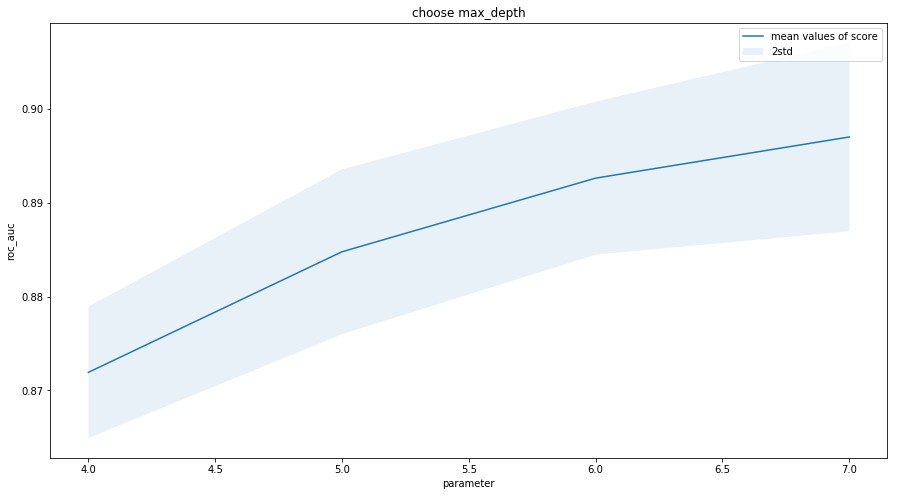

In [12]:
for model, param_name, grid, param_scale in zip(models, 
                                                param_names, 
                                                grids, 
                                                param_scales):
    search_and_draw(X_train, y_train, model, param_name, grid, param_scale)

Подберём параметр n_estimators в алгоритме случайный лес. Известно, что случайный лес не переобучается. Поэтому график качества будет монотонно возрастать. Следовательно, необходимо найти минимальное значение n_estimators, при котором качество не изменяется. 
Поскольку каждое дерево обучается независимо от остальных, достаточно обучить сразу лес из большого количества деревьев, а затем рассмотреть подмножества нужного размера из исходного множества деревьев.

In [0]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

In [0]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score

In [15]:
y_train.dtype

dtype('bool')

In [16]:
X_train.head(10)

,age,fnlwgt,educ-num,capital-gain,capital-loss,hours-per-week,workclass_ ?,workclass_ Federal-gov,workclass_ Local-gov,workclass_ Never-worked,workclass_ Private,workclass_ Self-emp-inc,workclass_ Self-emp-not-inc,workclass_ State-gov,workclass_ Without-pay,education_ 10th,education_ 11th,education_ 12th,education_ 1st-4th,education_ 5th-6th,education_ 7th-8th,education_ 9th,education_ Assoc-acdm,education_ Assoc-voc,education_ Bachelors,education_ Doctorate,education_ HS-grad,education_ Masters,education_ Preschool,education_ Prof-school,education_ Some-college,marital-status_ Divorced,marital-status_ Married-AF-spouse,marital-status_ Married-civ-spouse,marital-status_ Married-spouse-absent,marital-status_ Never-married,marital-status_ Separated,marital-status_ Widowed,occupation_ ?,occupation_ Adm-clerical,...,native-country_ Canada,native-country_ China,native-country_ Columbia,native-country_ Cuba,native-country_ Dominican-Republic,native-country_ Ecuador,native-country_ El-Salvador,native-country_ England,native-country_ France,native-country_ Germany,native-country_ Greece,native-country_ Guatemala,native-country_ Haiti,native-country_ Holand-Netherlands,native-country_ Honduras,native-country_ Hong,native-country_ Hungary,native-country_ India,native-country_ Iran,native-country_ Ireland,native-country_ Italy,native-country_ Jamaica,native-country_ Japan,native-country_ Laos,native-country_ Mexico,native-country_ Nicaragua,native-country_ Outlying-US(Guam-USVI-etc),native-country_ Peru,native-country_ Philippines,native-country_ Poland,native-country_ Portugal,native-country_ Puerto-Rico,native-country_ Scotland,native-country_ South,native-country_ Taiwan,native-country_ Thailand,native-country_ Trinadad&Tobago,native-country_ United-States,native-country_ Vietnam,native-country_ Yugoslavia
24639,20,385077,8,0,0,40,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
5514,21,140764,10,0,0,12,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
19777,64,312242,10,0,0,3,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
10781,26,227489,9,0,0,40,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
32239,21,180190,11,0,0,46,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
9876,58,150560,13,14084,0,40,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
5455,55,189664,9,0,0,40,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
8615,23,240398,13,0,0,15,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
29804,62,75478,13,0,0,40,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
15081,37,212005,11,0,0,40,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [0]:
max_trees = 200

values = np.arange(max_trees) + 1

kf = KFold(n_splits=5, shuffle=True, random_state=1234)

global_scores = []

for train_indices, val_indices in kf.split(X_train):
    scores = []
    
    X_train_kf = X_train.iloc[train_indices]
    y_train_kf = y_train.values[train_indices]
    
    X_val_kf = X_train.iloc[val_indices]
    y_val_kf = y_train.values[val_indices]
    
    forest = RandomForestClassifier(n_estimators=max_trees, n_jobs=-1)
    forest.fit(X_train_kf, y_train_kf)
    trees = forest.estimators_
    
    for number_of_trees in values:
        thinned_forest = RandomForestClassifier(n_estimators=number_of_trees)
        
        thinned_forest.n_classes_ = 2
        thinned_forest.estimators_ = trees[:number_of_trees]

        scores.append(roc_auc_score(y_val_kf, thinned_forest.predict_proba(X_val_kf)[:, 1]))
    
    scores = np.array(scores)
    
    global_scores.append(scores)

global_scores = np.stack(global_scores, axis=0)

In [18]:
global_scores

array([[0.7353022 , 0.807722  , 0.83639771, 0.85210425, 0.86185878,
        0.87036016, 0.87612782, 0.88008759, 0.88251527, 0.88467789,
        0.88629725, 0.8873891 , 0.89009926, 0.891584  , 0.89184301,
        0.893241  , 0.8937143 , 0.89401273, 0.89503836, 0.89608494,
        0.89696501, 0.8974968 , 0.89775853, 0.89801087, 0.89861284,
        0.89955505, 0.9000737 , 0.90100809, 0.90170787, 0.90165458,
        0.90166657, 0.90180693, 0.90219555, 0.90239576, 0.90278772,
        0.90305101, 0.90313046, 0.90341388, 0.90338572, 0.90315726,
        0.90305768, 0.90317666, 0.90297697, 0.90324746, 0.90361961,
        0.90377466, 0.90396767, 0.90418571, 0.90432898, 0.90438508,
        0.90460374, 0.90427038, 0.90424994, 0.90417851, 0.90422189,
        0.90426224, 0.90404838, 0.90418727, 0.90442752, 0.90447162,
        0.90460707, 0.9049201 , 0.90482855, 0.90489935, 0.90496598,
        0.90506535, 0.90513741, 0.90499601, 0.90511728, 0.90511968,
        0.90532051, 0.9054691 , 0.90569777, 0.90

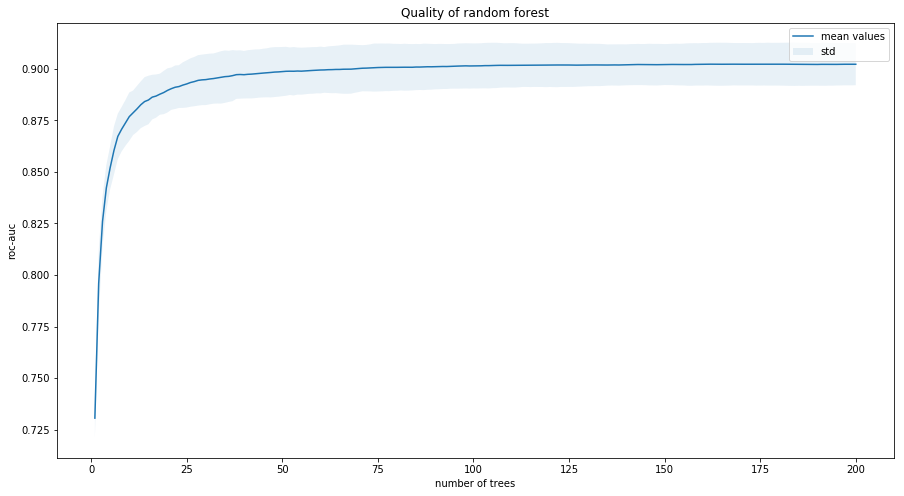

In [19]:
mean_cross_val_score = global_scores.mean(axis=0)
std_cross_val_score = global_scores.std(axis=0)

plt.figure(figsize=(15,8))
plt.title('Quality of random forest')

plt.plot(values, mean_cross_val_score, label='mean values')
plt.fill_between(values, 
                 mean_cross_val_score - 2 * std_cross_val_score, 
                 mean_cross_val_score + 2 * std_cross_val_score,  
                 label='std', alpha=0.1)
plt.legend()
plt.xlabel('number of trees')
plt.ylabel('roc-auc')

plt.show()

Нормируем признаки и проделаем тот же эксперимент с алгоритмом ближайших соседей. Посмотрим, изменилось ли качество предсказания. В этот раз будем обучаться только на численных признаках: иначе KNeighborsClassifier будет учиться вечность.

In [0]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# scaler.fit()
# X_train = scaler.transform(X_train)
# X_train = scaler.fit_transform(X_train)

#ВАШ КОД: преобразуйте выборки X_train и X_test
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

{'n_neighbors': 100}


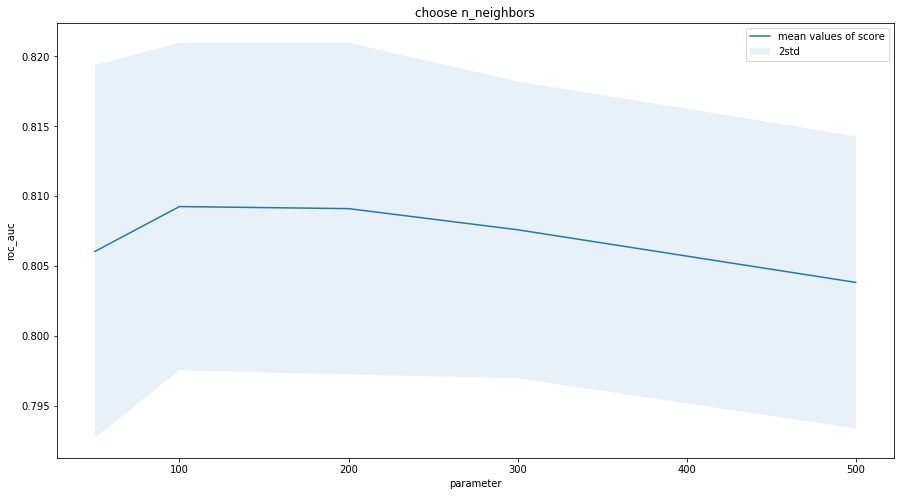

{'max_depth': 8}


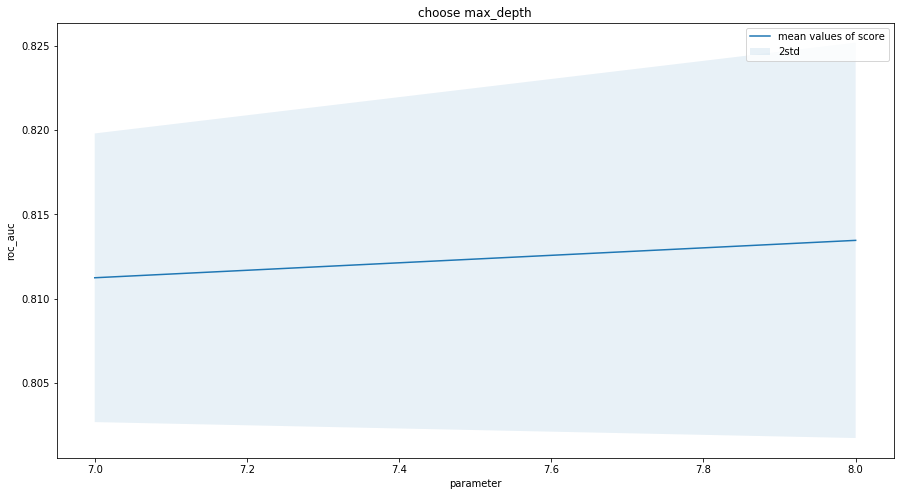

In [21]:
models = [KNeighborsClassifier(), DecisionTreeClassifier()]
param_names = ['n_neighbors', 'max_depth']
grids = [[50,100, 200, 300, 500], [7,8]]
param_scales = ['ordinary', 'ordinary']

for model, param_name, grid, param_scale in zip(models, 
                                                param_names, 
                                                grids, 
                                                param_scales):
    search_and_draw(X_train[:, numeric_indices], y_train, model, param_name, grid, param_scale)

Проведём эксперимент над алгоритмом ближайших соседей для оптимального значения глубины из предыдущего пункта на всех признаках.

Сделаем выводы. Какой из алгоритмов сработал лучше всего? Выберем его и вычислим итоговое качество на test.

In [0]:
model = KNeighborsClassifier(n_neighbors=100)

#ВАШ КОД
model.fit(X_train, y_train)

y_predicted = model.predict_proba(X_test)
#ВАШ КОД: предскажите вероятности на test

In [0]:
y_predicted = model.predict_proba(X_test)[:, 1]

In [0]:
from sklearn.metrics import roc_auc_score, roc_curve

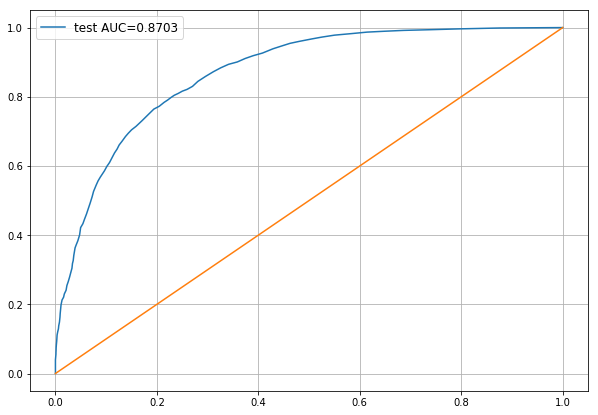

In [25]:
auc = roc_auc_score(y_test, y_predicted)

plt.figure(figsize=(10,7))
plt.plot(*roc_curve(y_test, y_predicted)[:2], label='test AUC=%.4f' % auc)
plt.legend(fontsize='large')
plt.plot(np.linspace(0,1,100), np.linspace(0,1,100))
plt.grid()
plt.show()

## Что ещё можно делать:

Мы подбирали оптимальный одномерный параметр для алгоритма. Можно также:

* Искать по сетке не только численные гиперпараметры, но и категориальные, например, метрику в алгоритме ближайших соседей или критерий ветвления в решающем дереве.

* Искать оптимальный параметр по многомерной сетке. Перебрать все возможные варианты здесь не выйдет, потому что на это уйдёт слишком много времени. Зато можно перебирать случайные точки по сетке. Эта процедура называется Grid Random Search.

# Стекинг

Идея стекинга состоит в том, чтобы обучать разнообразные алгоритмы и использовать их в качестве новых признаков объектов. 

Чтобы избежать переобучения, необходимо разделить обучающую выборку на n фолдов. Для предсказания ответов на k-ом фолде алгоритм обучается на оставшихся n-1 фолдах и предсказывает ответ на k-ом фолде. Такую схему обучения-предсказания реализует функция sklearn.model_selection.cross_val_predict.

In [0]:
from sklearn.model_selection import cross_val_predict

Будем работать с тем же самым датасетом, что и ранее. Посмотрим, сумеем ли мы побить результаты случайного леса с помощью стекинга.

In [0]:
def compute_meta_feature(model, X_train, X_test, y_train, cv):
    try:
        train_answers = cross_val_predict(model, X_train, y_train, cv=cv, method='predict_proba')[:, 1]
        model.fit(X_train, y_train)
        return train_answers, model.predict_proba(X_test)[:, 1]
    
    except Exception:
        train_answers = cross_val_predict(model, X_train, y_train, cv=cv, method='predict')[:, 1]
        model.fit(X_train, y_train)
        return train_answers, model.predict(X_test)[:, 1]

In [0]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

In [0]:
models = [RandomForestClassifier()]#Список ваших любимых моделей из предыдущих пунктов

In [0]:
meta_features_train = np.zeros((X_train.shape[0], 0))
meta_features_test = np.zeros((X_test.shape[0], 0))

In [46]:
for model in models:
    train, test = compute_meta_feature(model, X_train, X_test, y_train, 5)
    meta_features_train = np.append(meta_features_train, train.reshape((train.size, 1)), axis=1)
    meta_features_test = np.append(meta_features_test, test.reshape((test.size, 1)), axis=1)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The de

In [70]:
np.reshape(meta_features_train,(-1,1))
#meta_features_train.shape

array([[0. ],
       [0. ],
       [0.1],
       ...,
       [0. ],
       [0. ],
       [0.3]])

Выберите итоговую модель, которая будет обучаться на метапризнаках. Обучите её и сравните качество на test.

In [74]:
stacking_model = RandomForestClassifier()#ВАШ КОД: заведите модель

stacking_model.fit(meta_features_train[:,0].reshape(-1, 1), y_train) #ВАШ КОД: обучите модель

y_predicted = stacking_model.predict_proba(meta_features_test[:,0])[:,1] #ВАШ КОД

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


ValueError: ignored

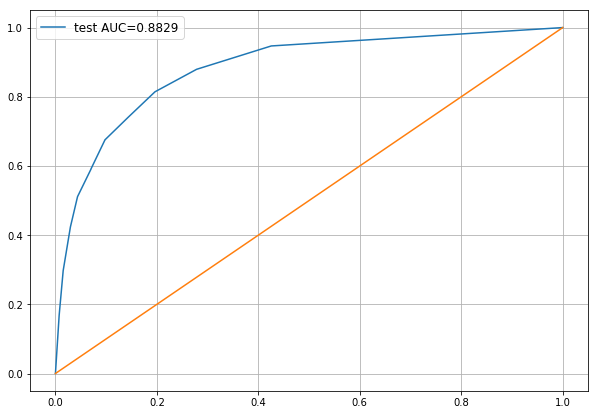

In [35]:
auc = roc_auc_score(y_test, y_predicted)

plt.figure(figsize=(10,7))
plt.plot(*roc_curve(y_test, y_predicted)[:2], label='test AUC=%.4f' % auc)
plt.legend(fontsize='large')
plt.plot(np.linspace(0,1,100), np.linspace(0,1,100))
plt.grid()
plt.show()

# Бустинг

Попробуем в пару-тройку строк побить всё то качество, которого мы так усердно добивались.

In [0]:
# Если не работает ячейка ниже
!pip install catboost

!conda config --add channels conda-forge
!conda install catboost

In [0]:
import catboost

In [0]:
boosting_model = catboost.CatBoostClassifier(learning_rate=0.05, n_estimators=1000, eval_metric='AUC')

boosting_model.fit(X_train, y_train.astype('float'), plot=True, eval_set=(X_test, y_test.astype('float')))

y_predicted = boosting_model.predict_proba(X_test)[:, 1]

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.8688991	best: 0.8688991 (0)	total: 38.3ms	remaining: 38.2s
1:	test: 0.8818335	best: 0.8818335 (1)	total: 75.1ms	remaining: 37.5s
2:	test: 0.8865533	best: 0.8865533 (2)	total: 113ms	remaining: 37.4s
3:	test: 0.8919966	best: 0.8919966 (3)	total: 150ms	remaining: 37.4s
4:	test: 0.8956503	best: 0.8956503 (4)	total: 190ms	remaining: 37.9s
5:	test: 0.8967574	best: 0.8967574 (5)	total: 229ms	remaining: 37.9s
6:	test: 0.8968898	best: 0.8968898 (6)	total: 260ms	remaining: 36.8s
7:	test: 0.8965375	best: 0.8968898 (6)	total: 299ms	remaining: 37s
8:	test: 0.8970712	best: 0.8970712 (8)	total: 337ms	remaining: 37.1s
9:	test: 0.8982829	best: 0.8982829 (9)	total: 376ms	remaining: 37.2s
10:	test: 0.8992942	best: 0.8992942 (10)	total: 415ms	remaining: 37.4s
11:	test: 0.8995851	best: 0.8995851 (11)	total: 456ms	remaining: 37.6s
12:	test: 0.9004888	best: 0.9004888 (12)	total: 542ms	remaining: 41.1s
13:	test: 0.9007764	best: 0.9007764 (13)	total: 580ms	remaining: 40.9s
14:	test: 0.9011572	best: 

119:	test: 0.9189426	best: 0.9189426 (119)	total: 4.8s	remaining: 35.2s
120:	test: 0.9190151	best: 0.9190151 (120)	total: 4.85s	remaining: 35.2s
121:	test: 0.9192541	best: 0.9192541 (121)	total: 4.88s	remaining: 35.1s
122:	test: 0.9193238	best: 0.9193238 (122)	total: 4.91s	remaining: 35s
123:	test: 0.9193576	best: 0.9193576 (123)	total: 4.93s	remaining: 34.8s
124:	test: 0.9193696	best: 0.9193696 (124)	total: 4.96s	remaining: 34.7s
125:	test: 0.9194992	best: 0.9194992 (125)	total: 5s	remaining: 34.7s
126:	test: 0.9195473	best: 0.9195473 (126)	total: 5.05s	remaining: 34.7s
127:	test: 0.9195747	best: 0.9195747 (127)	total: 5.08s	remaining: 34.6s
128:	test: 0.9196008	best: 0.9196008 (128)	total: 5.11s	remaining: 34.5s
129:	test: 0.9196365	best: 0.9196365 (129)	total: 5.14s	remaining: 34.4s
130:	test: 0.9197180	best: 0.9197180 (130)	total: 5.17s	remaining: 34.3s
131:	test: 0.9197766	best: 0.9197766 (131)	total: 5.21s	remaining: 34.3s
132:	test: 0.9198055	best: 0.9198055 (132)	total: 5.25s	r

238:	test: 0.9247839	best: 0.9247839 (238)	total: 8.95s	remaining: 28.5s
239:	test: 0.9247982	best: 0.9247982 (239)	total: 8.99s	remaining: 28.5s
240:	test: 0.9248524	best: 0.9248524 (240)	total: 9.02s	remaining: 28.4s
241:	test: 0.9248845	best: 0.9248845 (241)	total: 9.06s	remaining: 28.4s
242:	test: 0.9249534	best: 0.9249534 (242)	total: 9.09s	remaining: 28.3s
243:	test: 0.9249800	best: 0.9249800 (243)	total: 9.12s	remaining: 28.3s
244:	test: 0.9249747	best: 0.9249800 (243)	total: 9.15s	remaining: 28.2s
245:	test: 0.9249709	best: 0.9249800 (243)	total: 9.19s	remaining: 28.2s
246:	test: 0.9250035	best: 0.9250035 (246)	total: 9.22s	remaining: 28.1s
247:	test: 0.9250574	best: 0.9250574 (247)	total: 9.26s	remaining: 28.1s
248:	test: 0.9250768	best: 0.9250768 (248)	total: 9.29s	remaining: 28s
249:	test: 0.9251057	best: 0.9251057 (249)	total: 9.32s	remaining: 28s
250:	test: 0.9250759	best: 0.9251057 (249)	total: 9.35s	remaining: 27.9s
251:	test: 0.9251633	best: 0.9251633 (251)	total: 9.39s

356:	test: 0.9280632	best: 0.9280787 (352)	total: 13.1s	remaining: 23.6s
357:	test: 0.9280545	best: 0.9280787 (352)	total: 13.2s	remaining: 23.6s
358:	test: 0.9280684	best: 0.9280787 (352)	total: 13.2s	remaining: 23.6s
359:	test: 0.9280769	best: 0.9280787 (352)	total: 13.2s	remaining: 23.5s
360:	test: 0.9280581	best: 0.9280787 (352)	total: 13.3s	remaining: 23.5s
361:	test: 0.9280709	best: 0.9280787 (352)	total: 13.3s	remaining: 23.4s
362:	test: 0.9280793	best: 0.9280793 (362)	total: 13.3s	remaining: 23.4s
363:	test: 0.9280884	best: 0.9280884 (363)	total: 13.3s	remaining: 23.3s
364:	test: 0.9280887	best: 0.9280887 (364)	total: 13.4s	remaining: 23.3s
365:	test: 0.9281235	best: 0.9281235 (365)	total: 13.4s	remaining: 23.3s
366:	test: 0.9281548	best: 0.9281548 (366)	total: 13.5s	remaining: 23.2s
367:	test: 0.9282244	best: 0.9282244 (367)	total: 13.5s	remaining: 23.2s
368:	test: 0.9282398	best: 0.9282398 (368)	total: 13.5s	remaining: 23.2s
369:	test: 0.9282400	best: 0.9282400 (369)	total: 1

472:	test: 0.9291676	best: 0.9291676 (472)	total: 17.3s	remaining: 19.3s
473:	test: 0.9292163	best: 0.9292163 (473)	total: 17.3s	remaining: 19.3s
474:	test: 0.9292124	best: 0.9292163 (473)	total: 17.4s	remaining: 19.2s
475:	test: 0.9292268	best: 0.9292268 (475)	total: 17.4s	remaining: 19.2s
476:	test: 0.9292333	best: 0.9292333 (476)	total: 17.5s	remaining: 19.1s
477:	test: 0.9292474	best: 0.9292474 (477)	total: 17.5s	remaining: 19.1s
478:	test: 0.9292280	best: 0.9292474 (477)	total: 17.6s	remaining: 19.1s
479:	test: 0.9292331	best: 0.9292474 (477)	total: 17.6s	remaining: 19.1s
480:	test: 0.9292381	best: 0.9292474 (477)	total: 17.6s	remaining: 19s
481:	test: 0.9292371	best: 0.9292474 (477)	total: 17.7s	remaining: 19s
482:	test: 0.9292386	best: 0.9292474 (477)	total: 17.7s	remaining: 19s
483:	test: 0.9292408	best: 0.9292474 (477)	total: 17.7s	remaining: 18.9s
484:	test: 0.9292424	best: 0.9292474 (477)	total: 17.8s	remaining: 18.9s
485:	test: 0.9292562	best: 0.9292562 (485)	total: 17.8s	r

586:	test: 0.9296720	best: 0.9296811 (584)	total: 21.5s	remaining: 15.1s
587:	test: 0.9296807	best: 0.9296811 (584)	total: 21.6s	remaining: 15.1s
588:	test: 0.9296760	best: 0.9296811 (584)	total: 21.6s	remaining: 15.1s
589:	test: 0.9296705	best: 0.9296811 (584)	total: 21.6s	remaining: 15s
590:	test: 0.9296771	best: 0.9296811 (584)	total: 21.7s	remaining: 15s
591:	test: 0.9296774	best: 0.9296811 (584)	total: 21.7s	remaining: 15s
592:	test: 0.9296771	best: 0.9296811 (584)	total: 21.7s	remaining: 14.9s
593:	test: 0.9297200	best: 0.9297200 (593)	total: 21.8s	remaining: 14.9s
594:	test: 0.9297223	best: 0.9297223 (594)	total: 21.8s	remaining: 14.8s
595:	test: 0.9297218	best: 0.9297223 (594)	total: 21.8s	remaining: 14.8s
596:	test: 0.9297228	best: 0.9297228 (596)	total: 21.9s	remaining: 14.8s
597:	test: 0.9297332	best: 0.9297332 (597)	total: 21.9s	remaining: 14.7s
598:	test: 0.9297262	best: 0.9297332 (597)	total: 21.9s	remaining: 14.7s
599:	test: 0.9297285	best: 0.9297332 (597)	total: 22s	rem

699:	test: 0.9300482	best: 0.9300735 (692)	total: 25.9s	remaining: 11.1s
700:	test: 0.9300478	best: 0.9300735 (692)	total: 26s	remaining: 11.1s
701:	test: 0.9300471	best: 0.9300735 (692)	total: 26s	remaining: 11s
702:	test: 0.9300471	best: 0.9300735 (692)	total: 26s	remaining: 11s
703:	test: 0.9300471	best: 0.9300735 (692)	total: 26.1s	remaining: 11s
704:	test: 0.9300502	best: 0.9300735 (692)	total: 26.1s	remaining: 10.9s
705:	test: 0.9300550	best: 0.9300735 (692)	total: 26.2s	remaining: 10.9s
706:	test: 0.9300546	best: 0.9300735 (692)	total: 26.2s	remaining: 10.9s
707:	test: 0.9300545	best: 0.9300735 (692)	total: 26.3s	remaining: 10.8s
708:	test: 0.9300468	best: 0.9300735 (692)	total: 26.4s	remaining: 10.8s
709:	test: 0.9300497	best: 0.9300735 (692)	total: 26.4s	remaining: 10.8s
710:	test: 0.9300393	best: 0.9300735 (692)	total: 26.5s	remaining: 10.8s
711:	test: 0.9300539	best: 0.9300735 (692)	total: 26.5s	remaining: 10.7s
712:	test: 0.9300622	best: 0.9300735 (692)	total: 26.6s	remaini

817:	test: 0.9300772	best: 0.9301482 (791)	total: 30.8s	remaining: 6.86s
818:	test: 0.9300999	best: 0.9301482 (791)	total: 30.9s	remaining: 6.82s
819:	test: 0.9301024	best: 0.9301482 (791)	total: 30.9s	remaining: 6.79s
820:	test: 0.9301049	best: 0.9301482 (791)	total: 31s	remaining: 6.75s
821:	test: 0.9301045	best: 0.9301482 (791)	total: 31s	remaining: 6.71s
822:	test: 0.9301164	best: 0.9301482 (791)	total: 31s	remaining: 6.67s
823:	test: 0.9301143	best: 0.9301482 (791)	total: 31.2s	remaining: 6.66s
824:	test: 0.9301256	best: 0.9301482 (791)	total: 31.2s	remaining: 6.62s
825:	test: 0.9301150	best: 0.9301482 (791)	total: 31.2s	remaining: 6.58s
826:	test: 0.9301146	best: 0.9301482 (791)	total: 31.3s	remaining: 6.54s
827:	test: 0.9301109	best: 0.9301482 (791)	total: 31.3s	remaining: 6.5s
828:	test: 0.9301372	best: 0.9301482 (791)	total: 31.3s	remaining: 6.46s
829:	test: 0.9301362	best: 0.9301482 (791)	total: 31.4s	remaining: 6.43s
830:	test: 0.9301310	best: 0.9301482 (791)	total: 31.4s	re

932:	test: 0.9302561	best: 0.9302847 (926)	total: 35.5s	remaining: 2.55s
933:	test: 0.9302512	best: 0.9302847 (926)	total: 35.6s	remaining: 2.51s
934:	test: 0.9302401	best: 0.9302847 (926)	total: 35.6s	remaining: 2.48s
935:	test: 0.9302395	best: 0.9302847 (926)	total: 35.6s	remaining: 2.44s
936:	test: 0.9302364	best: 0.9302847 (926)	total: 35.7s	remaining: 2.4s
937:	test: 0.9302435	best: 0.9302847 (926)	total: 35.7s	remaining: 2.36s
938:	test: 0.9302409	best: 0.9302847 (926)	total: 35.8s	remaining: 2.32s
939:	test: 0.9302434	best: 0.9302847 (926)	total: 35.8s	remaining: 2.29s
940:	test: 0.9302449	best: 0.9302847 (926)	total: 35.9s	remaining: 2.25s
941:	test: 0.9302535	best: 0.9302847 (926)	total: 35.9s	remaining: 2.21s
942:	test: 0.9302699	best: 0.9302847 (926)	total: 36s	remaining: 2.17s
943:	test: 0.9302742	best: 0.9302847 (926)	total: 36s	remaining: 2.13s
944:	test: 0.9302725	best: 0.9302847 (926)	total: 36s	remaining: 2.1s
945:	test: 0.9302734	best: 0.9302847 (926)	total: 36.1s	rem

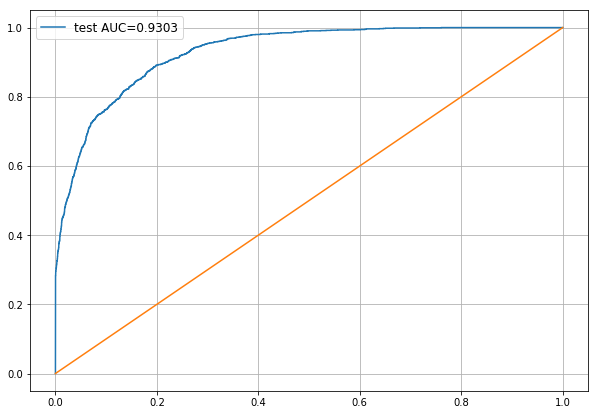

In [0]:
auc = roc_auc_score(y_test, y_predicted)

plt.figure(figsize=(10,7))
plt.plot(*roc_curve(y_test, y_predicted)[:2], label='test AUC=%.4f' % auc)
plt.legend(fontsize='large')
plt.plot(np.linspace(0,1,100), np.linspace(0,1,100))
plt.grid()
plt.show()

# Машинное обучение PO3 09.07-